# Project 11: Working with Geocoded Data

## Building Maps in _geopandas_

In this lesson we will download COVID-19 data from data.world. We will normalize the data to compare spread between counties. Were we to simply plot the total number of cases or deaths by county, the results would be biased as counties with larger populations would likely have more cases and more deaths. We will observe how the spread developed across the country, starting in the northeast, eventually making its way to other regions.

### Installing geopandas

Although there is a geopandas installation available using the *conda install* command in you command line shell, that package is incomplete for our purposes. We will need to install dependencies - in this order: *GDAL*,*Fiona*, and *Shapely* - for geopandas before installing geopandas. I have included the *.whl* files for each of these packages in the same folder is this notebook. Download the files and save them to your local folder. To install, use  the command:

> *pip install filename*

If you are using a machine for which you are not the administrator, use the command:

> *pip install filename --user*

Install the libraries using these commands from an administrator shell or using --user at the end of the statement: 

>*pip install GDAL-3.1.4-cp37-cp37m-win_amd64.whl*

>*pip install Fiona-1.8.17-cp37-cp37m-win_amd64.whl*

>*pip install Shapely-1.7.1-cp37-cp37m-win_amd64.whl*

If you are using Python 3.8, use the following wheels:

>*pip install GDAL-3.1.4-cp38-cp38-win_amd64.whl*

>*pip install Fiona-1.8.17-cp38-cp38-win_amd64.whl*

>*pip install Shapely-1.7.1-cp38-cp38-win_amd64.whl*

If you are using a mac, you may install the appropriate module by selecting the version.

> *pip install -v GDAL==3.1.4*

> *pip install -v Fiona==1.8.17*

> *pip install -v Shapely==1.7.1*

Finally, install geopandas:

> *pip install geopandas*

In [1]:
# !pip install GDAL-3.1.4-cp37-cp37m-win_amd64.whl
# !pip install Fiona-1.8.17-cp37-cp37m-win_amd64.whl
# !pip install Shapely-1.7.1-cp37-cp37m-win_amd64.whl 
# !pip install geopandas
# !pip install datadotworld

In [2]:
#COVID19Map.py
### import all modules that we will use in this lesson
import geopandas
import numpy as np
import pandas as pd
# We won't actually use datetime directly. Since the dataframe index will use 
# data formatted as datetime64, I import it in case I need to use the datetime
# module to troubleshoot later 
import datetime
# you could technically call many of the submodules from matplotlib using mpl., 
#but for convenience we explicitly import submodules. These will be used for 
# constructing visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
# If you choose to make a dynamic visualization for the homework
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick

def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = geopandas.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data

plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.xmargin'] = 0
plt.rcParams.update({'font.size': 32})

#if "data_processed" not in locals():
fips_name = "fips_code"
# covid_filename = "COVID19DataAP.csv"
# rename_FIPS matches map_data FIPS with COVID19 FIPS name
map_data = import_geo_data(
    filename = "countiesWithStatesAndPopulation.shp",
    index_col = "Date", FIPS_name= fips_name)
# dates will be used to create a geopandas DataFrame with multiindex 


Now we have separately imported the geodata and downloaded the COVID-19 data. Let's check both dataframes.

First, let's use the *.plot()* method to preview how geopandas works.

<AxesSubplot:>

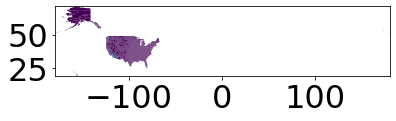

In [3]:
map_data.plot(column = "Population")

The size of the figure and the area covered is too extensive. Before plotting, we will increase the size of the figure and reduce the area plotted (we will exclude Alaska and Hawaii for this purpose). 

Next, let's check the geodataframe.

In [4]:
map_data

STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD  \
fips_code                                                               
21007           21      007  00516850  0500000US21007    Ballard   06   
21017           21      017  00516855  0500000US21017    Bourbon   06   
21031           21      031  00516862  0500000US21031     Butler   06   
21065           21      065  00516879  0500000US21065     Estill   06   
21069           21      069  00516881  0500000US21069    Fleming   06   
...            ...      ...       ...             ...        ...  ...   
31073           31      073  00835858  0500000US31073     Gosper   06   
39075           39      075  01074050  0500000US39075     Holmes   06   
48171           48      171  01383871  0500000US48171  Gillespie   06   
55079           55      079  01581100  0500000US55079  Milwaukee   06   
26139           26      139  01623012  0500000US26139     Ottawa   06   

                ALAND      AWATER  Population      state  \
fips_code                                                  
21007       639387454    69473325      7888.0   Kentucky   
21017       750439351     4829777     19788.0   Kentucky   
21031      1103571974    13943044     12879.0   Kentucky   
21065       655509930     6516335     14106.0   Kentucky   
21069       902727151     7182793     14581.0   Kentucky   
...               ...         ...         ...        ...   
31073      1186616237    11831826      1990.0   Nebraska   
39075      1094405866     3695230     43960.0       Ohio   
48171      2740719114     9012764     26988.0      Texas   
55079       625440563  2455383635    945726.0  Wisconsin   
26139      1459502408  2765830983    291830.0   Michigan   

                                                    geometry  
fips_code                                                     
21007      POLYGON ((-89.18137 37.04630, -89.17938 37.053...  
21017      POLYGON ((-84.44266 38.28324, -84.44114 38.283...  
21031      POLYGON ((-86.94486 37.07341, -86.94346 37.074...  
21065      POLYGON ((-84.12662 37.64540, -84.12483 37.646...  
21069      POLYGON ((-83.98428 38.44549, -83.98246 38.450...  
...                                                      ...  
31073      POLYGON ((-100.09510 40.43866, -100.08937 40.4...  
39075      POLYGON ((-82.22066 40.66758, -82.19327 40.667...  
48171      POLYGON ((-99.30400 30.49983, -99.28234 30.499...  
55079      POLYGON ((-88.06959 42.86726, -88.06959 42.872...  
26139      POLYGON ((-86.26432 43.11830, -86.25103 43.118...  

[3142 rows x 11 columns]

We can see that counties are identified by a state, with reference to the states fip code, and by a county level fip code. Together, these make the total fip code. We will use the fip code to align the data frames.

Notice also that each observation is associated with an entry under **geometry**. Each entry has identified with it the shape and location of the county identified by a series of coordinates representing the perimeter of the county.

Next, let's call the COVID-19 data.

We are almost ready to create our first map! Much of the same structure for plotting other visualizations in *matplotlib* using *pandas* also applies to using *geopandas* to create maps. We will initiate a figure using *plt.subplots()*. Since we are plotting time series data, we will need to plot only one date at a time. Let's start with the most recent data available.

To start, we need to select data from counties  within the 48 states, otherwise Alaska and Hawaii will be include. This allows the area represented to be much smaller. The measures that are slected are rough estimates, but all that matters is that the 48 states reside within the boundaries chosen. Similar to the *data_processed* variable, I include a *map_bounded* variable so that this computation will not be repeated when the script is run multiple times.

In [5]:
import pandas as pd
#import unemployment data
u_data = pd.read_csv(
    "countyUnemploymentData.csv", encoding = "latin1", parse_dates = True, index_col="date")
# drop observations with missing fips codes
u_data.reset_index(inplace = True)
index = u_data["fips_code"].dropna(axis = 0).index
u_data = u_data.loc[index]

u_data["fips_code"] = u_data["fips_code"].astype(int)
u_data.set_index(["fips_code", "date"], inplace = True)
u_data = u_data[list(u_data.keys())[-4:]]

C:\Users\JLCat\AppData\Local\Temp\ipykernel_25096\2406869057.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  u_data = pd.read_csv(


In [6]:
u_data

Labor Force Employed Unemployed Unemployment Rate
fips_code date                                                        
1001      2019-08-01      26,079   25,368        711               2.7
1003      2019-08-01      97,939   95,367      2,572               2.6
1005      2019-08-01       8,652    8,322        330               3.8
1007      2019-08-01       8,670    8,403        267               3.1
1009      2019-08-01      25,309   24,641        668               2.6
...                          ...      ...        ...               ...
72145     2021-06-01      12,993   11,580      1,413              10.9
72147     2021-06-01       2,610    2,288        322              12.3
72149     2021-06-01       6,940    6,152        788              11.4
72151     2021-06-01       8,352    7,480        872              10.4
72153     2021-06-01       9,212    8,127      1,085              10.4

[74037 rows x 4 columns]

Unlike the previous set of data, the unemployment data is monthly, not daily.

In [7]:
map_data = map_data.reset_index().set_index("fips_code")
# map_data.drop("date", axis = 1, inplace = True)
map_data

STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD  \
fips_code                                                               
21007           21      007  00516850  0500000US21007    Ballard   06   
21017           21      017  00516855  0500000US21017    Bourbon   06   
21031           21      031  00516862  0500000US21031     Butler   06   
21065           21      065  00516879  0500000US21065     Estill   06   
21069           21      069  00516881  0500000US21069    Fleming   06   
...            ...      ...       ...             ...        ...  ...   
31073           31      073  00835858  0500000US31073     Gosper   06   
39075           39      075  01074050  0500000US39075     Holmes   06   
48171           48      171  01383871  0500000US48171  Gillespie   06   
55079           55      079  01581100  0500000US55079  Milwaukee   06   
26139           26      139  01623012  0500000US26139     Ottawa   06   

                ALAND      AWATER  Population      state  \
fips_code                                                  
21007       639387454    69473325      7888.0   Kentucky   
21017       750439351     4829777     19788.0   Kentucky   
21031      1103571974    13943044     12879.0   Kentucky   
21065       655509930     6516335     14106.0   Kentucky   
21069       902727151     7182793     14581.0   Kentucky   
...               ...         ...         ...        ...   
31073      1186616237    11831826      1990.0   Nebraska   
39075      1094405866     3695230     43960.0       Ohio   
48171      2740719114     9012764     26988.0      Texas   
55079       625440563  2455383635    945726.0  Wisconsin   
26139      1459502408  2765830983    291830.0   Michigan   

                                                    geometry  
fips_code                                                     
21007      POLYGON ((-89.18137 37.04630, -89.17938 37.053...  
21017      POLYGON ((-84.44266 38.28324, -84.44114 38.283...  
21031      POLYGON ((-86.94486 37.07341, -86.94346 37.074...  
21065      POLYGON ((-84.12662 37.64540, -84.12483 37.646...  
21069      POLYGON ((-83.98428 38.44549, -83.98246 38.450...  
...                                                      ...  
31073      POLYGON ((-100.09510 40.43866, -100.08937 40.4...  
39075      POLYGON ((-82.22066 40.66758, -82.19327 40.667...  
48171      POLYGON ((-99.30400 30.49983, -99.28234 30.499...  
55079      POLYGON ((-88.06959 42.86726, -88.06959 42.872...  
26139      POLYGON ((-86.26432 43.11830, -86.25103 43.118...  

[3142 rows x 11 columns]

In [8]:
#COVID19Map.py
# . . .
import copy as copy
def create_merged_geo_dataframe(data, map_data, dates):
    data_frame_initialized = False
    # use groupby to generate a df with only the fips_code index
    # then save that index as the variable counties
    matching_gpd = {}
    counties =data.groupby("fips_code").mean().index
    for key, val in data.items():
        matching_gpd[key] = copy.copy(map_data[map_data.index.isin(counties)])
        for date in dates:
            val_slice = val[val.index.get_level_values("date") == date]
            val_slice = val_slice.reset_index(drop = False).set_index("fips_code")
            matching_gpd[key][date] = val_slice[key]

    return matching_gpd

# dates will be used to create a geopandas DataFrame with multiindex 
# dates = sorted(list(set(u_data.index.get_level_values("date"))))
dates = u_data.groupby("date").mean().index
u_data = create_merged_geo_dataframe(u_data, map_data, dates)

u_data

C:\Users\JLCat\AppData\Local\Temp\ipykernel_25096\1908469300.py:27: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  dates = u_data.groupby("date").mean().index
C:\Users\JLCat\AppData\Local\Temp\ipykernel_25096\1908469300.py:9: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  counties =data.groupby("fips_code").mean().index


{'Labor Force':            STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD  \
 fips_code                                                               
 21007           21      007  00516850  0500000US21007    Ballard   06   
 21017           21      017  00516855  0500000US21017    Bourbon   06   
 21031           21      031  00516862  0500000US21031     Butler   06   
 21065           21      065  00516879  0500000US21065     Estill   06   
 21069           21      069  00516881  0500000US21069    Fleming   06   
 ...            ...      ...       ...             ...        ...  ...   
 31073           31      073  00835858  0500000US31073     Gosper   06   
 39075           39      075  01074050  0500000US39075     Holmes   06   
 48171           48      171  01383871  0500000US48171  Gillespie   06   
 55079           55      079  01581100  0500000US55079  Milwaukee   06   
 26139           26      139  01623012  0500000US26139     Ottawa   06   
 
                 ALAN

In [9]:
# change values to numeric values
for key in u_data.keys():
    if u_data[key][dates[0]].dtypes == object:
        for date in dates:
            u_data[key][date] = pd.to_numeric(u_data[key][date], errors = "coerce")

In [10]:
#COVID19Map.py
#. . . 

# only include observations within these boundaries
# this will shrink the size of the map
def select_data_within_bounds(data, minx, miny, maxx, maxy):
    data = data[data.bounds["maxx"] <= maxx]
    data = data[data.bounds["maxy"] <= maxy]
    data = data[data.bounds["minx"] >= minx]
    data = data[data.bounds["miny"] >= miny]
    
    return data

date = dates[-1]
for key, val in u_data.items():
    df = u_data[key]    
    minx = df.bounds["minx"].min()
    miny = df.bounds["miny"].min()
    maxx = -58
    maxy = df.bounds["maxy"].max()
    # find counties using only 1 date, only performs operation once instead of 
    # several hundred times
    bounded_data =  select_data_within_bounds(df, minx, miny, maxx, maxy)
    u_data[key] = bounded_data
#     counties = bounded_data.groupby("fips_code").mean().index
#     covid_map_data =covid_data[covid_data.index.get_level_values("fips_code").isin(counties)]
u_data

{'Labor Force':            STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD  \
 fips_code                                                               
 21007           21      007  00516850  0500000US21007    Ballard   06   
 21017           21      017  00516855  0500000US21017    Bourbon   06   
 21031           21      031  00516862  0500000US21031     Butler   06   
 21065           21      065  00516879  0500000US21065     Estill   06   
 21069           21      069  00516881  0500000US21069    Fleming   06   
 ...            ...      ...       ...             ...        ...  ...   
 31073           31      073  00835858  0500000US31073     Gosper   06   
 39075           39      075  01074050  0500000US39075     Holmes   06   
 48171           48      171  01383871  0500000US48171  Gillespie   06   
 55079           55      079  01581100  0500000US55079  Milwaukee   06   
 26139           26      139  01623012  0500000US26139     Ottawa   06   
 
                 ALAN

C:\Users\JLCat\AppData\Local\Temp\ipykernel_25096\2817614358.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(vals)#[int(x) for x in vals])


<class 'geopandas.geodataframe.GeoDataFrame'>


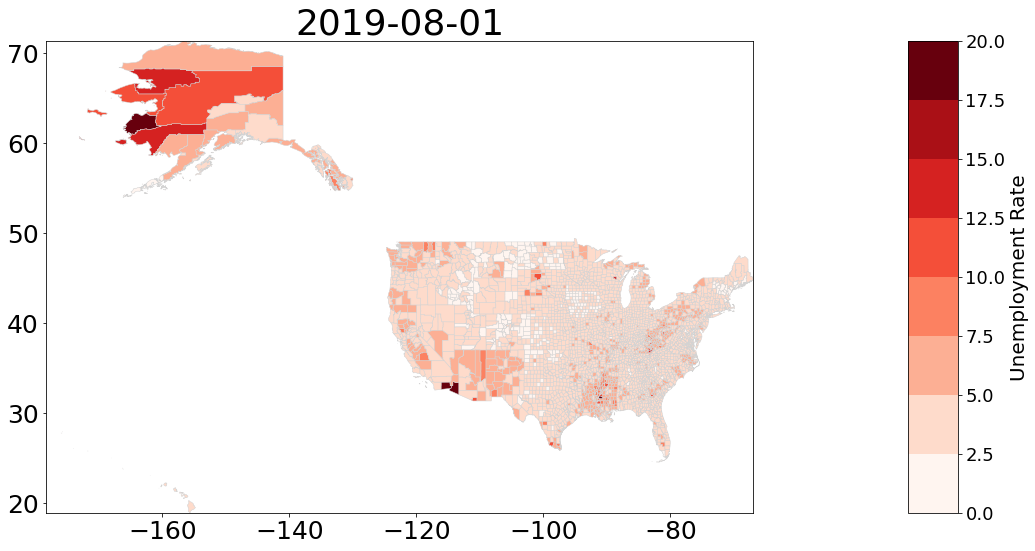

<class 'geopandas.geodataframe.GeoDataFrame'>


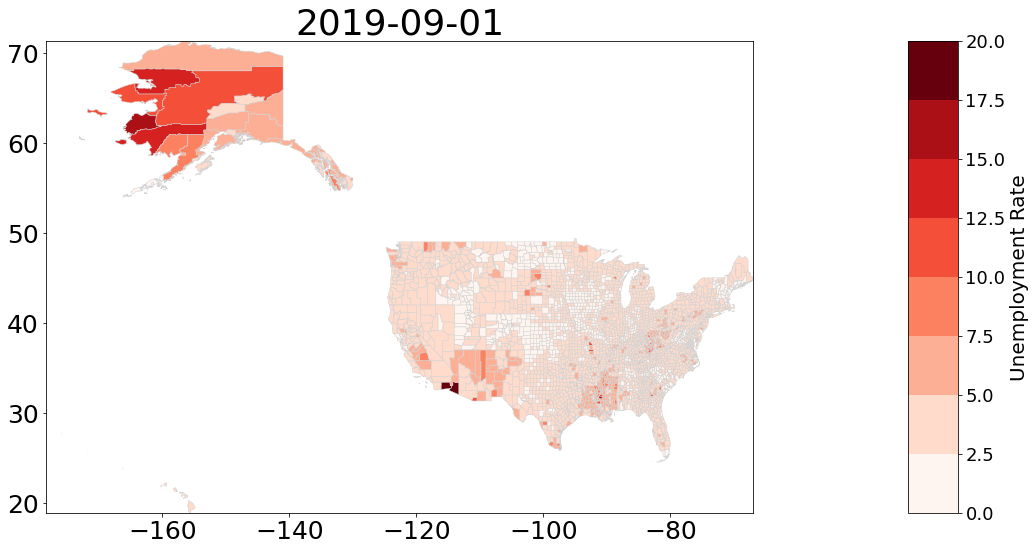

<class 'geopandas.geodataframe.GeoDataFrame'>


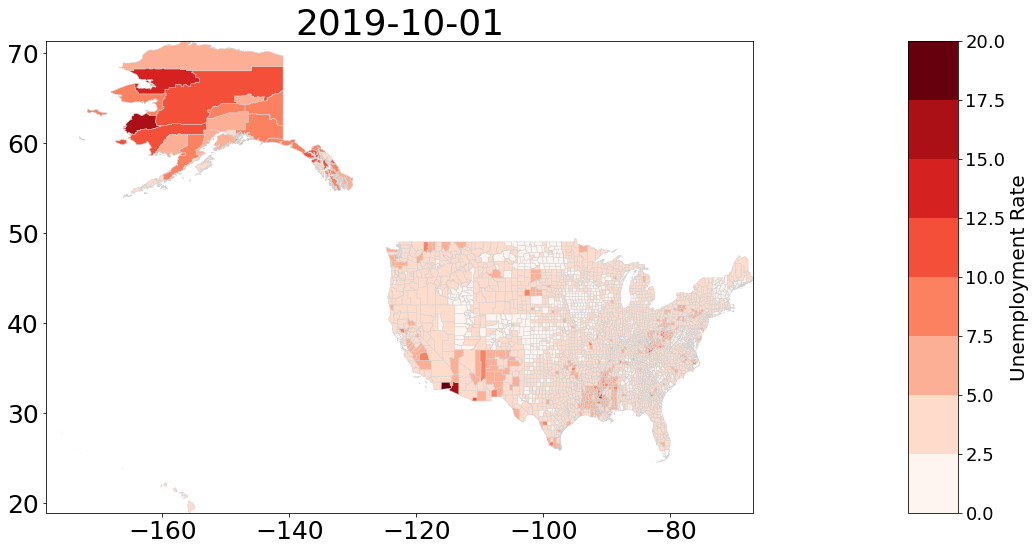

<class 'geopandas.geodataframe.GeoDataFrame'>


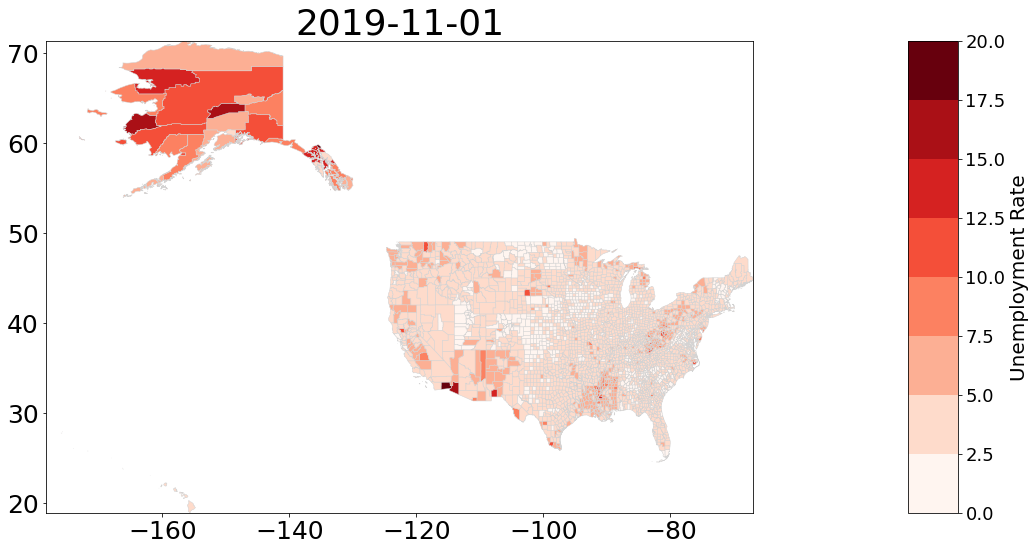

<class 'geopandas.geodataframe.GeoDataFrame'>


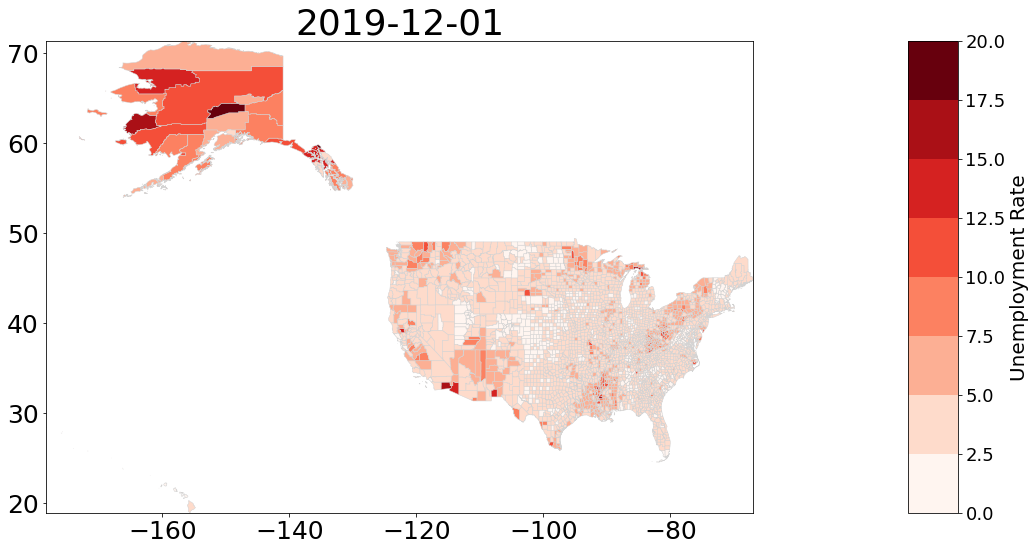

<class 'geopandas.geodataframe.GeoDataFrame'>


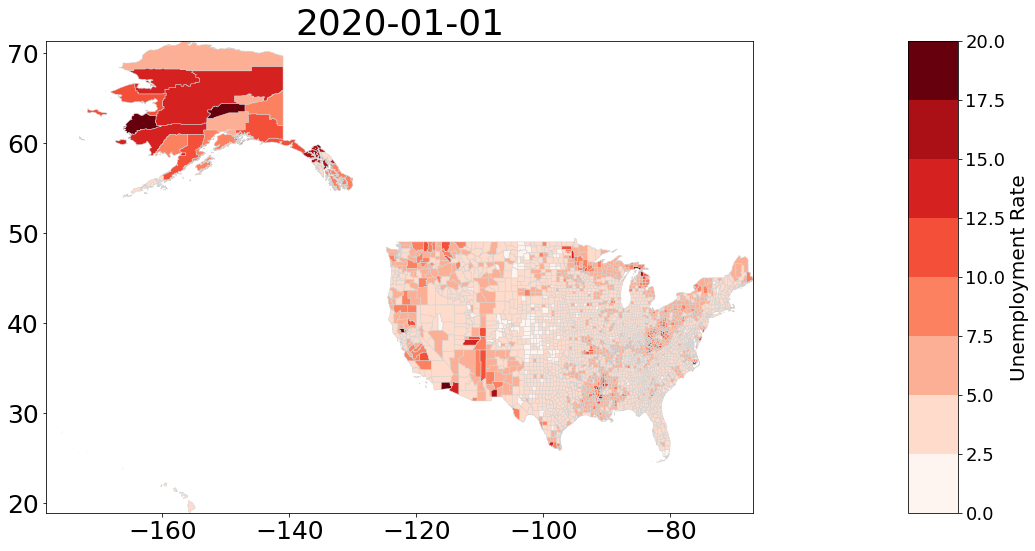

<class 'geopandas.geodataframe.GeoDataFrame'>


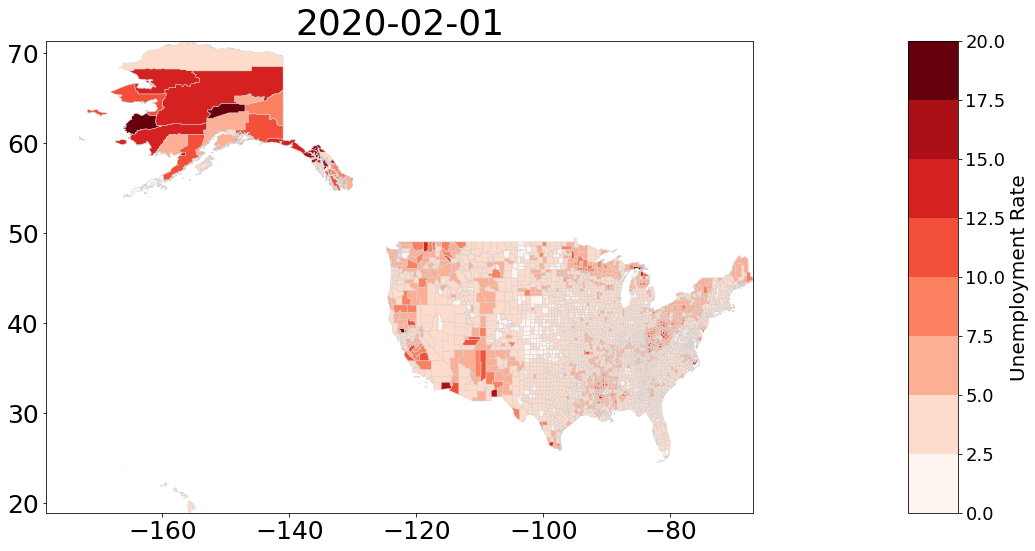

<class 'geopandas.geodataframe.GeoDataFrame'>


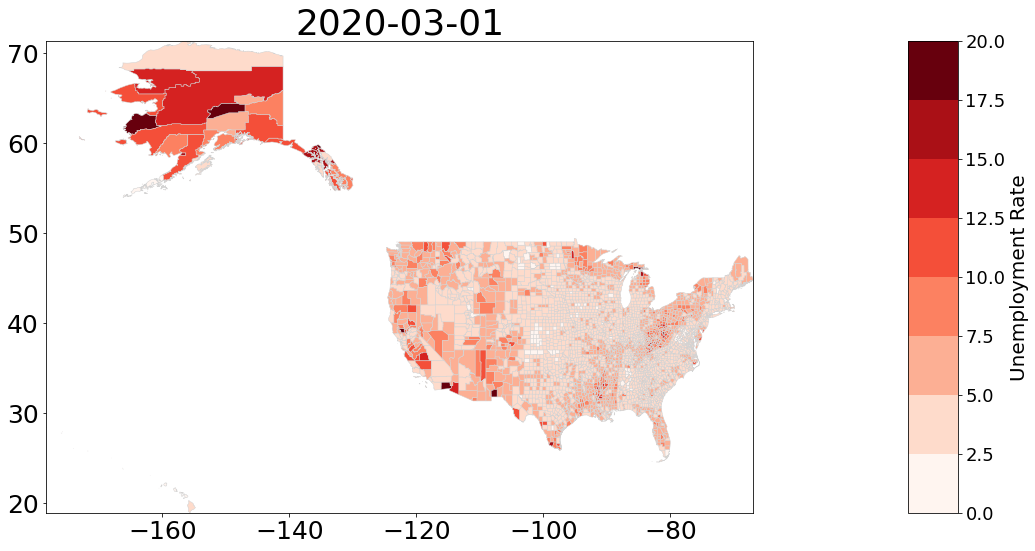

<class 'geopandas.geodataframe.GeoDataFrame'>


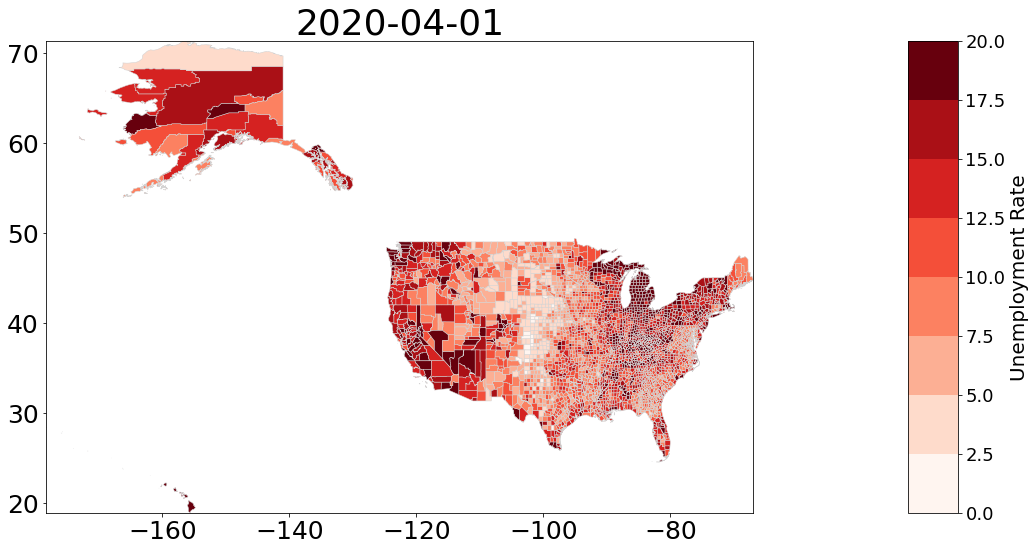

<class 'geopandas.geodataframe.GeoDataFrame'>


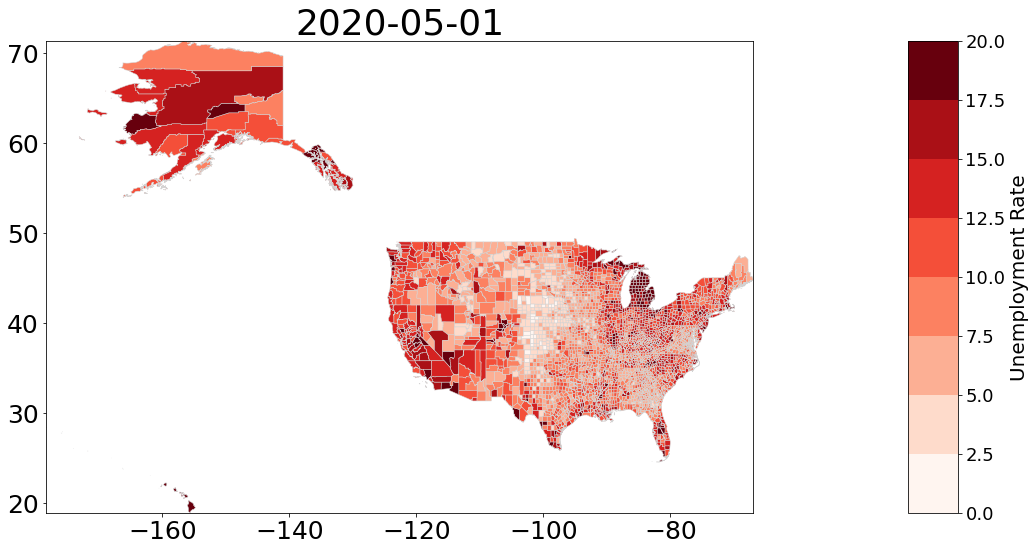

<class 'geopandas.geodataframe.GeoDataFrame'>


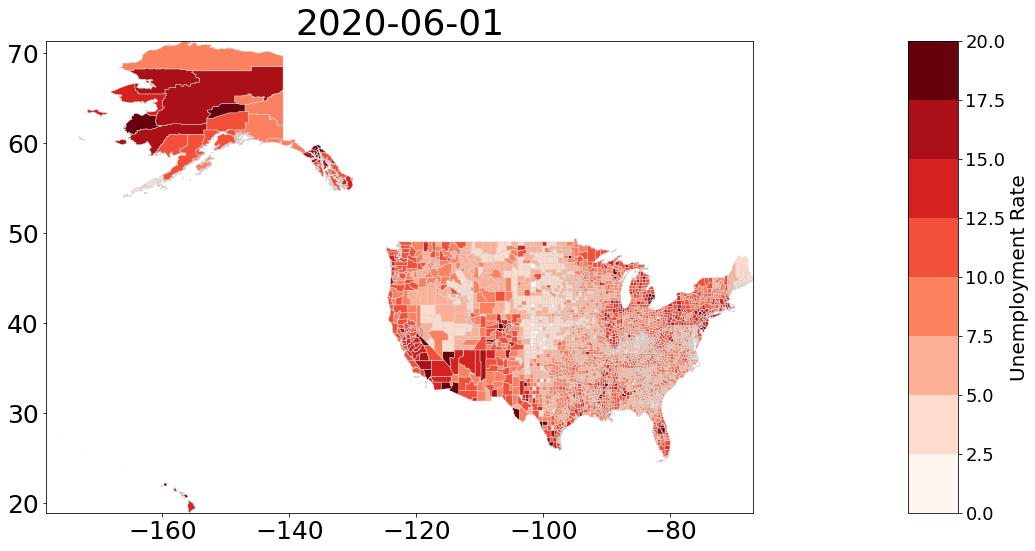

<class 'geopandas.geodataframe.GeoDataFrame'>


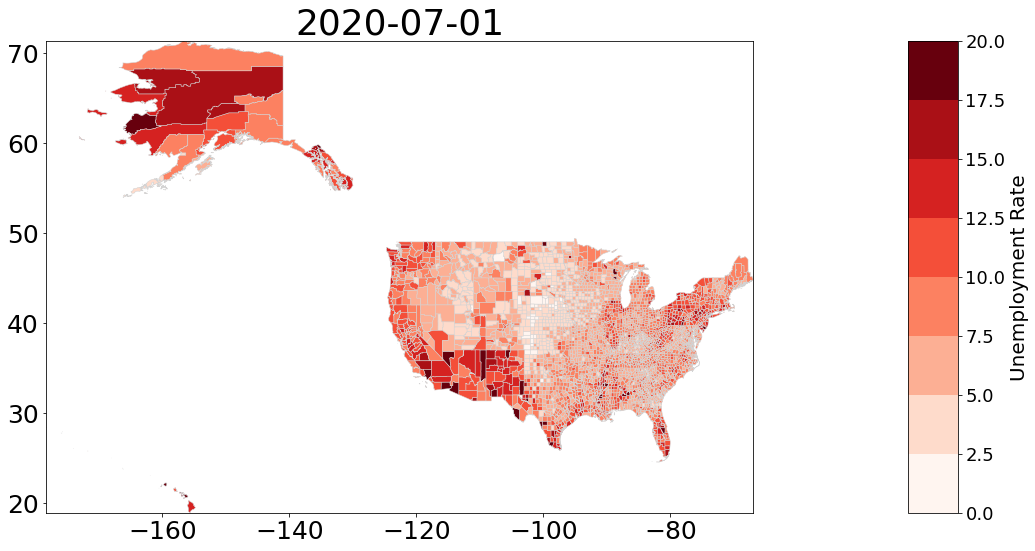

<class 'geopandas.geodataframe.GeoDataFrame'>


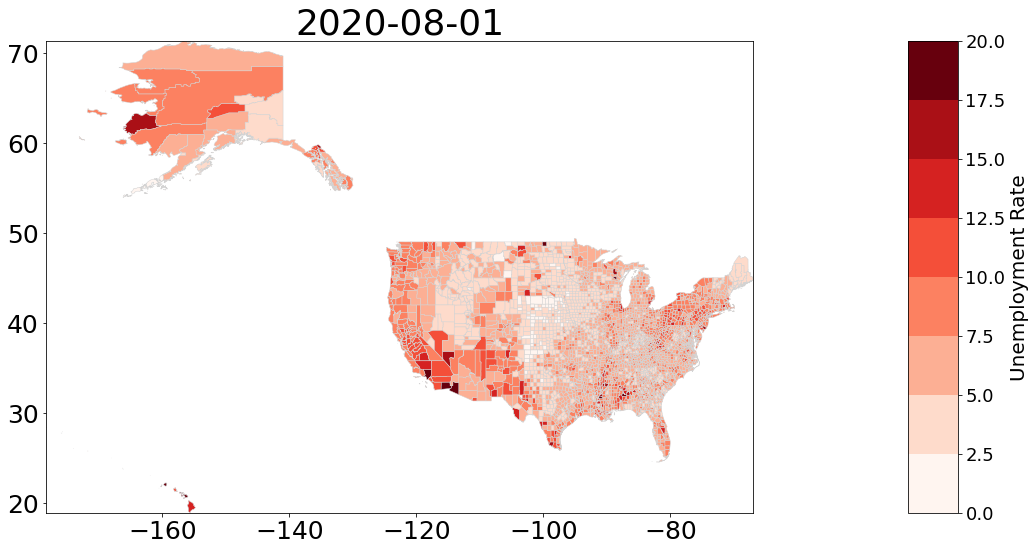

<class 'geopandas.geodataframe.GeoDataFrame'>


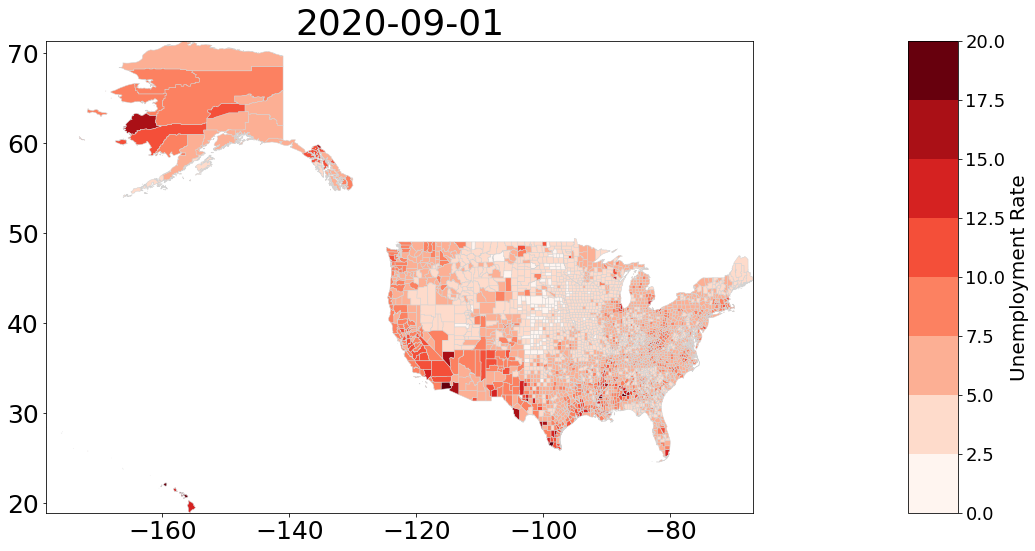

<class 'geopandas.geodataframe.GeoDataFrame'>


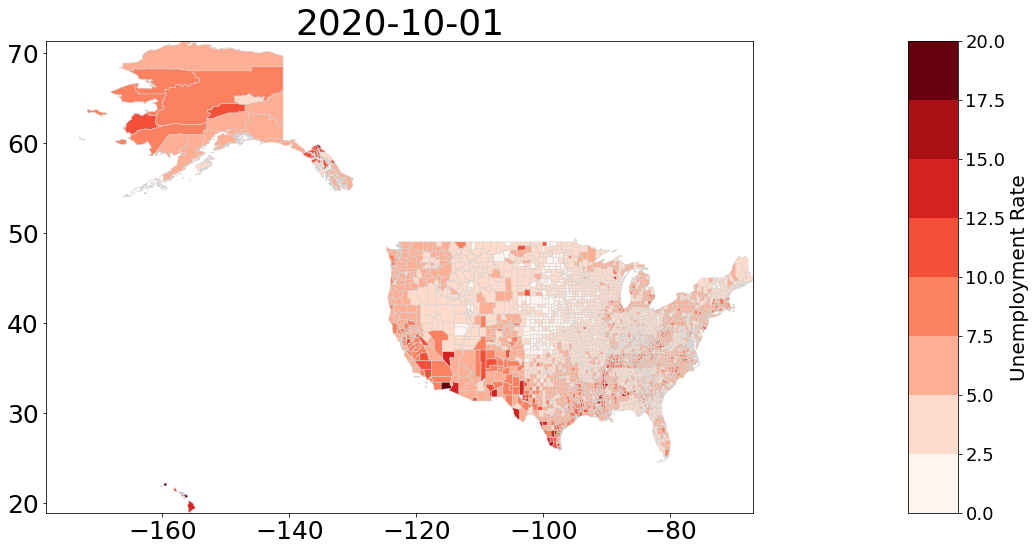

<class 'geopandas.geodataframe.GeoDataFrame'>


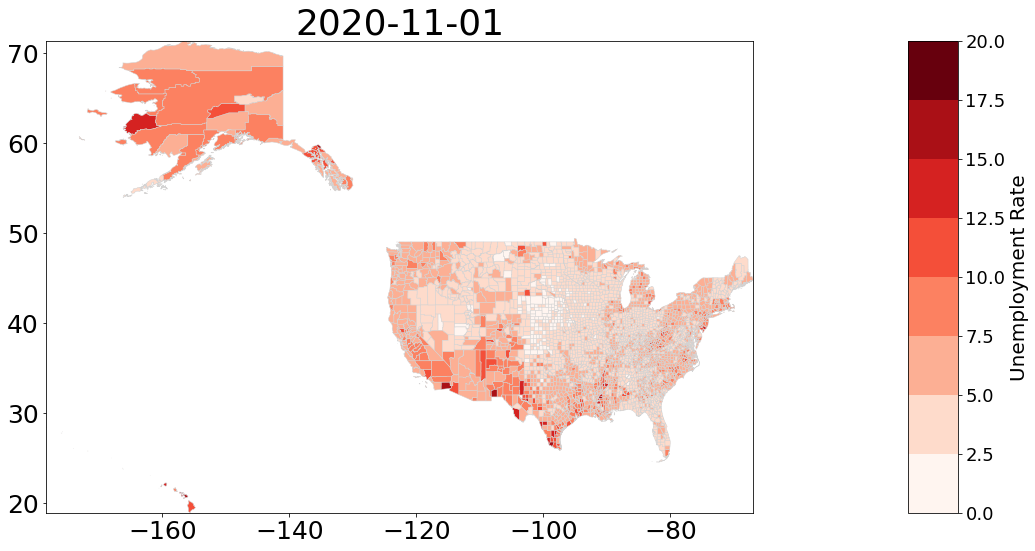

<class 'geopandas.geodataframe.GeoDataFrame'>


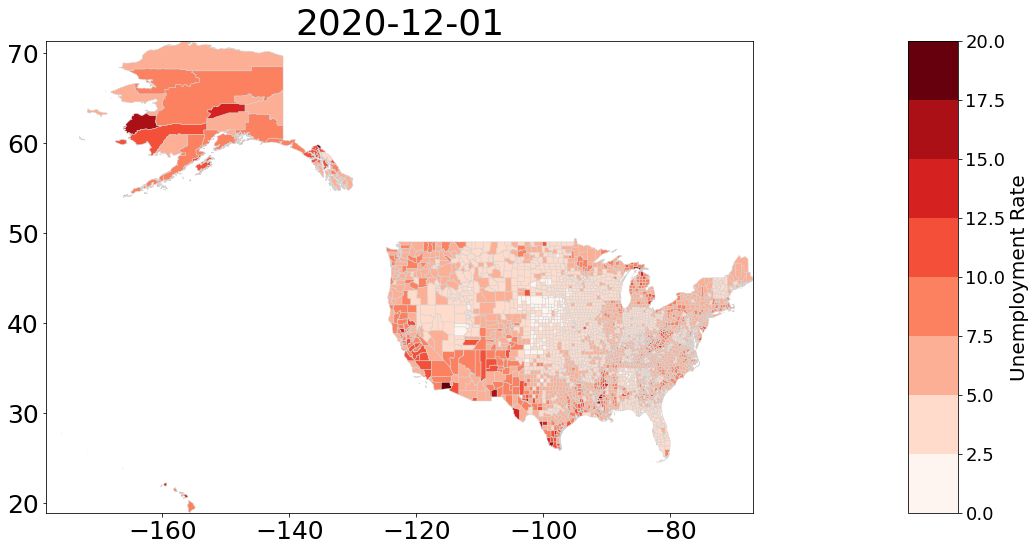

<class 'geopandas.geodataframe.GeoDataFrame'>


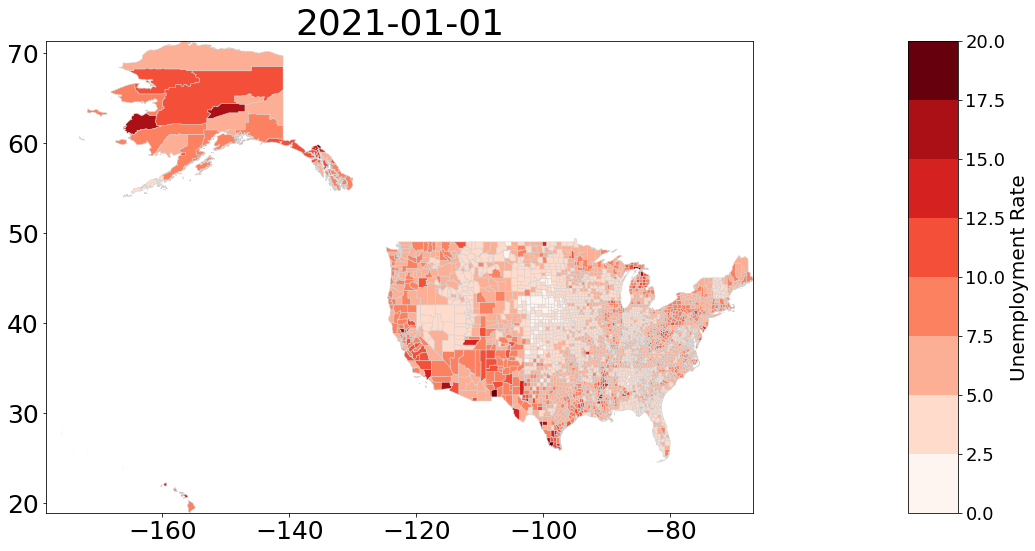

<class 'geopandas.geodataframe.GeoDataFrame'>


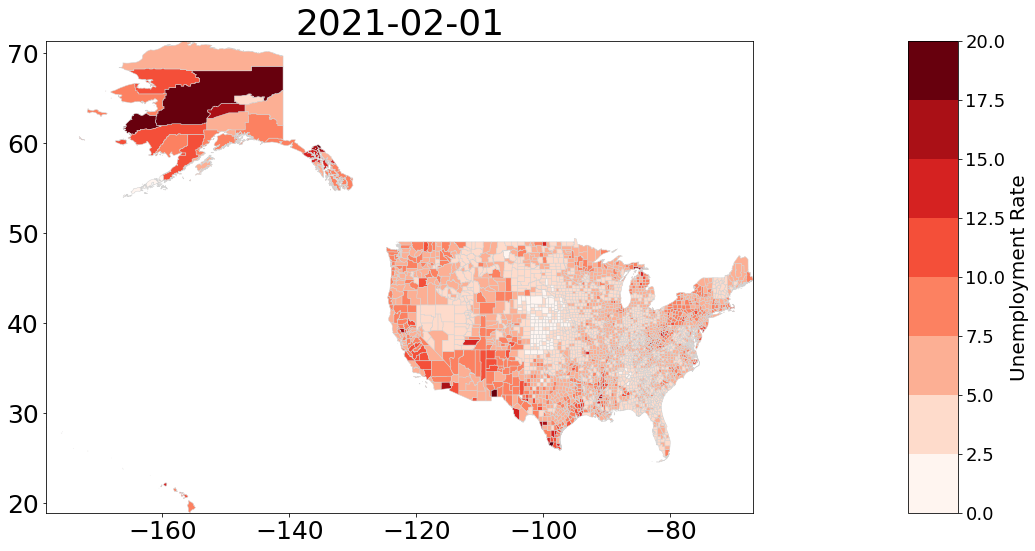

<class 'geopandas.geodataframe.GeoDataFrame'>


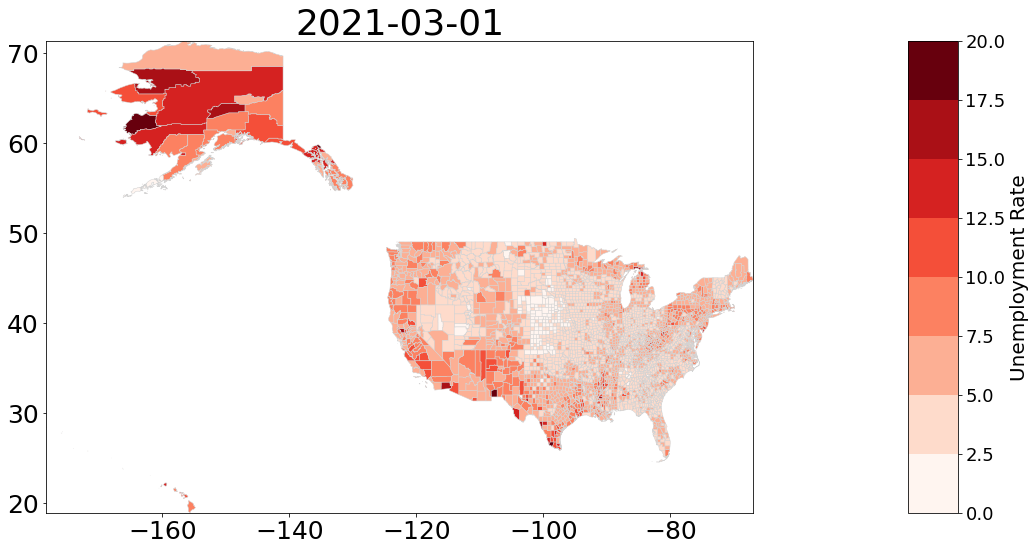

<class 'geopandas.geodataframe.GeoDataFrame'>


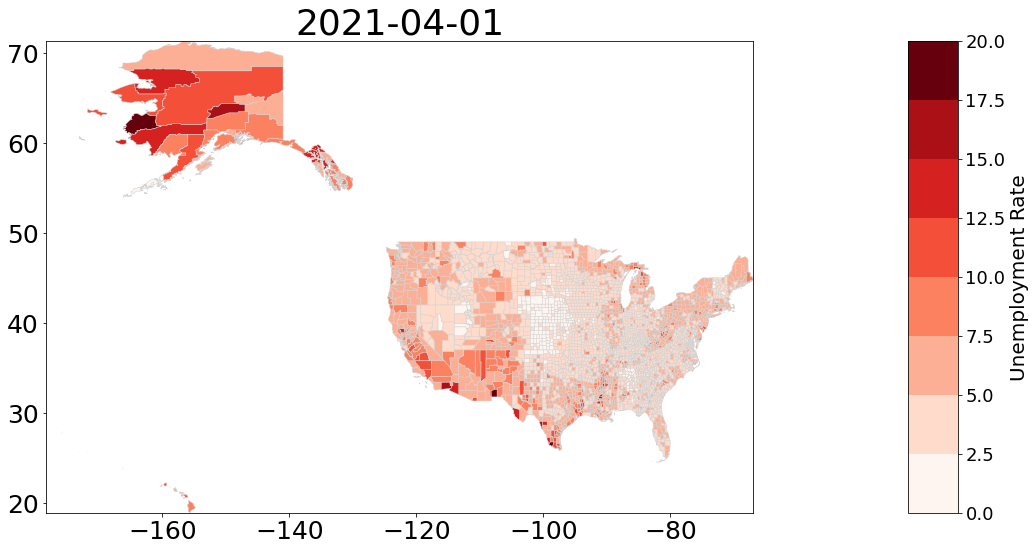

<class 'geopandas.geodataframe.GeoDataFrame'>


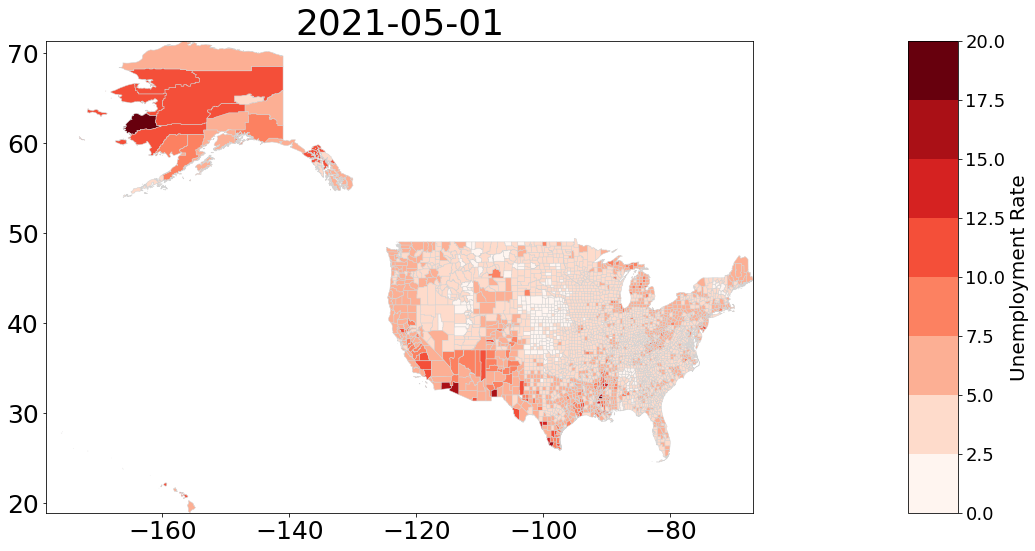

<class 'geopandas.geodataframe.GeoDataFrame'>


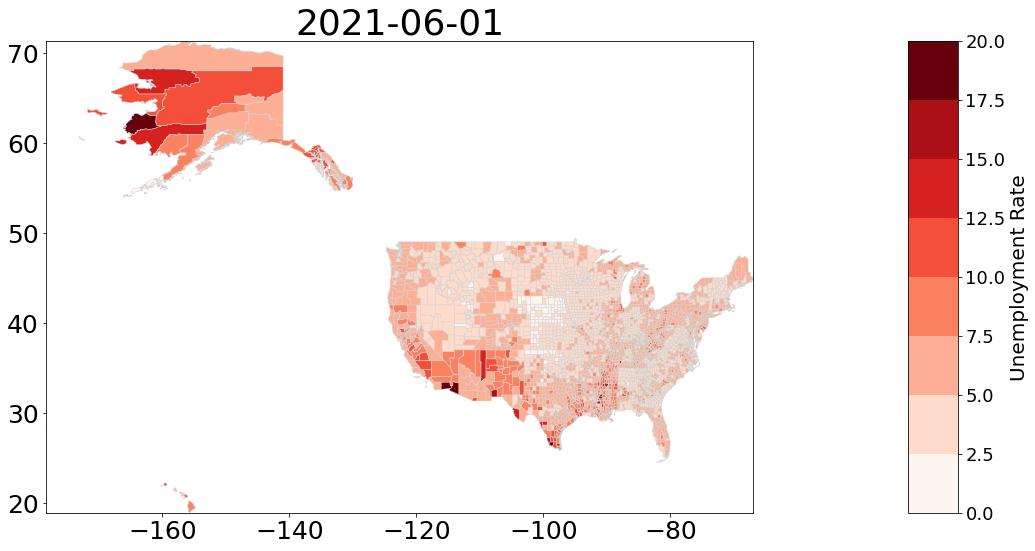

In [13]:
key = "Unemployment Rate"
df = u_data[key]#.dropna(axis=0)
pp = PdfPages("County Unemployment Rate.pdf")
for date in dates:
    fig, ax = plt.subplots(figsize=(19,9),
                          subplot_kw = {"aspect":"equal"})
    plt.rcParams.update({"font.size": 30})

    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    vmin = 0
    #vmax = u_data[key].fillna(0).max()
    vmax = 20
    cmap = cm.get_cmap("Reds", 8)
    norm = cm.colors.Normalize(vmin=vmin, vmax=vmax)
    ### add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # prepare space for colorbar
    divider = make_axes_locatable(ax)
    size = "5%"
    cax = divider.append_axes("right", size = size, pad = .1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap= cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    cbar.ax.set_yticklabels(vals)#[int(x) for x in vals])
    cbar.ax.set_ylabel(key, fontsize=20)

    # select data only from date
    print(type(df))
    df.plot(ax=ax, cax=ax, column = date,
            vmin=vmin, vmax=vmax,
            cmap=cmap, legend=False, 
            linewidth = .5, edgecolor="lightgrey",norm=norm)
    ax.set_title(str(date)[:10])
    plt.show()
#     pp.savefig(fig, bbox_inches = "tight")
    plt.close()
    
# close your pdf
pp.close()

In [14]:
# matplotlib will give us warning because we are setting the value a slice
import warnings
warnings.filterwarnings("ignore")
# Normalize Unemployment Feb-20 == 1
key = "Unemployment Rate"
new_key = "Normalized " + key + " (Feb 2020)"
# df.copy() makes a copy of the dataframe
u_data[new_key] = u_data[key]
# take the difference between the observed rate and the Feb rate
for date in dates:
    u_data[new_key][date] = u_data[key][date].sub(u_data[key][datetime.datetime(2020,2,1)])

In [15]:
u_data[new_key]

STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD  \
fips_code                                                               
21007           21      007  00516850  0500000US21007    Ballard   06   
21017           21      017  00516855  0500000US21017    Bourbon   06   
21031           21      031  00516862  0500000US21031     Butler   06   
21065           21      065  00516879  0500000US21065     Estill   06   
21069           21      069  00516881  0500000US21069    Fleming   06   
...            ...      ...       ...             ...        ...  ...   
31073           31      073  00835858  0500000US31073     Gosper   06   
39075           39      075  01074050  0500000US39075     Holmes   06   
48171           48      171  01383871  0500000US48171  Gillespie   06   
55079           55      079  01581100  0500000US55079  Milwaukee   06   
26139           26      139  01623012  0500000US26139     Ottawa   06   

                ALAND      AWATER  Population      state  ...  \
fips_code                                                 ...   
21007       639387454    69473325      7888.0   Kentucky  ...   
21017       750439351     4829777     19788.0   Kentucky  ...   
21031      1103571974    13943044     12879.0   Kentucky  ...   
21065       655509930     6516335     14106.0   Kentucky  ...   
21069       902727151     7182793     14581.0   Kentucky  ...   
...               ...         ...         ...        ...  ...   
31073      1186616237    11831826      1990.0   Nebraska  ...   
39075      1094405866     3695230     43960.0       Ohio  ...   
48171      2740719114     9012764     26988.0      Texas  ...   
55079       625440563  2455383635    945726.0  Wisconsin  ...   
26139      1459502408  2765830983    291830.0   Michigan  ...   

          2020-09-01 00:00:00  2020-10-01 00:00:00  2020-11-01 00:00:00  \
fips_code                                                                 
21007                     4.7                  4.9                  5.2   
21017                     4.2                  3.8                  3.9   
21031                     4.9                  4.6                  4.6   
21065                     5.6                  5.3                  5.3   
21069                     5.0                  4.6                  4.7   
...                       ...                  ...                  ...   
31073                     2.0                  1.9                  1.8   
39075                     3.2                  2.0                  2.1   
48171                     4.5                  3.9                  3.9   
55079                     7.7                  6.7                  6.1   
26139                     4.6                  4.1                  4.4   

           2020-12-01 00:00:00  2021-01-01 00:00:00  2021-02-01 00:00:00  \
fips_code                                                                  
21007                      5.7                  5.3                  5.3   
21017                      4.4                  4.1                  4.1   
21031                      5.1                  5.1                  5.1   
21065                      6.0                  5.9                  5.7   
21069                      5.6                  5.6                  5.9   
...                        ...                  ...                  ...   
31073                      1.5                  1.7                  2.0   
39075                      2.6                  3.1                  3.1   
48171                      3.8                  4.4                  4.4   
55079                      5.6                  5.9                  6.2   
26139                      5.1                  4.8                  4.2   

           2021-03-01 00:00:00  2021-04-01 00:00:00  2021-05-01 00:00:00  \
fips_code                                                                  
21007                      5.5                  4.0                  4.3   
21017                 

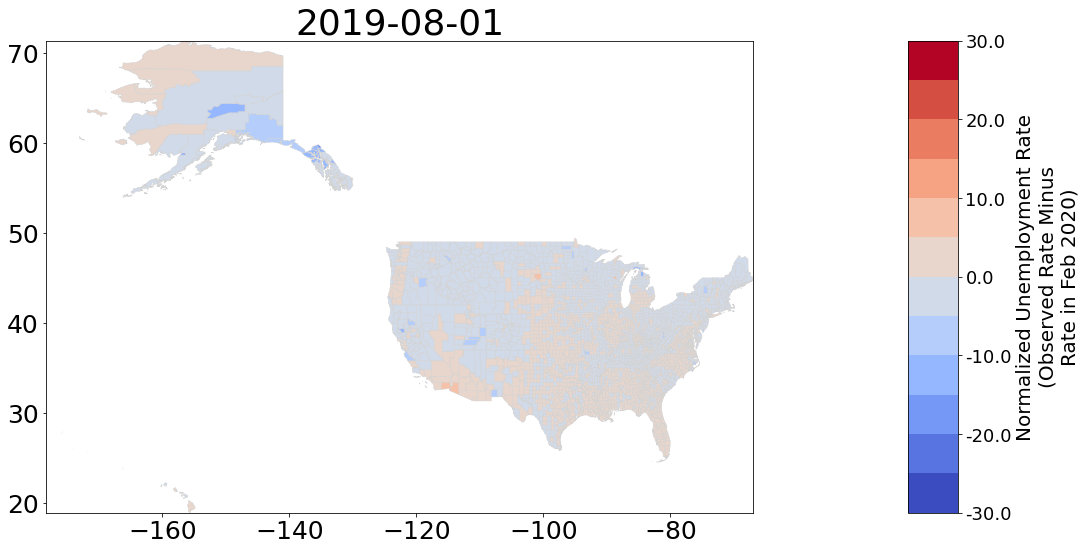

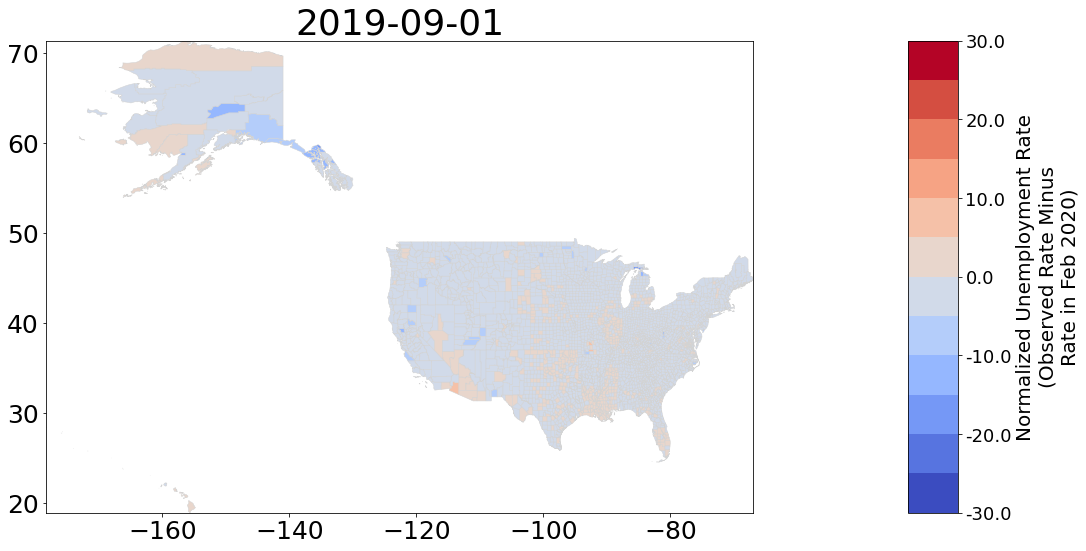

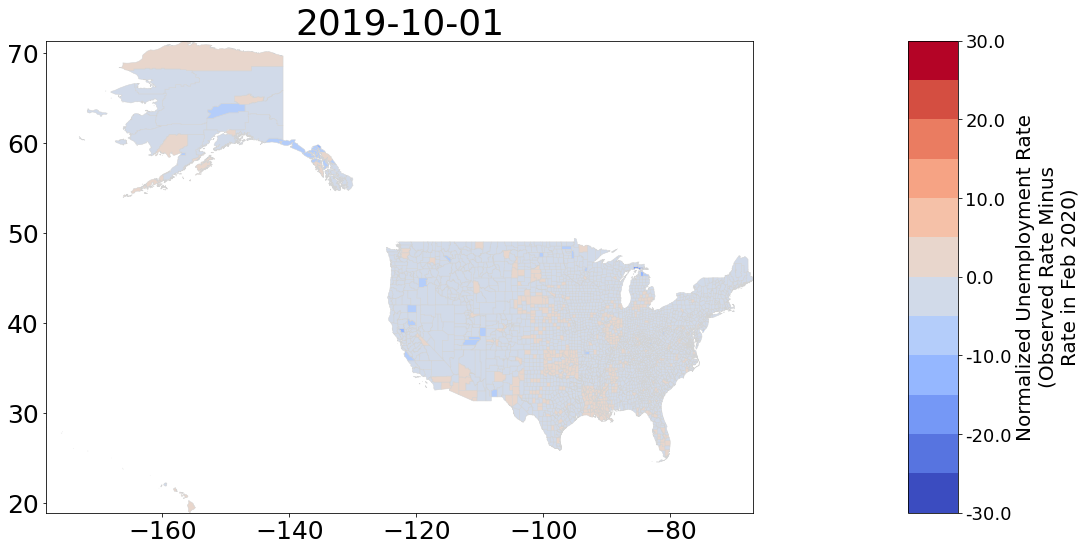

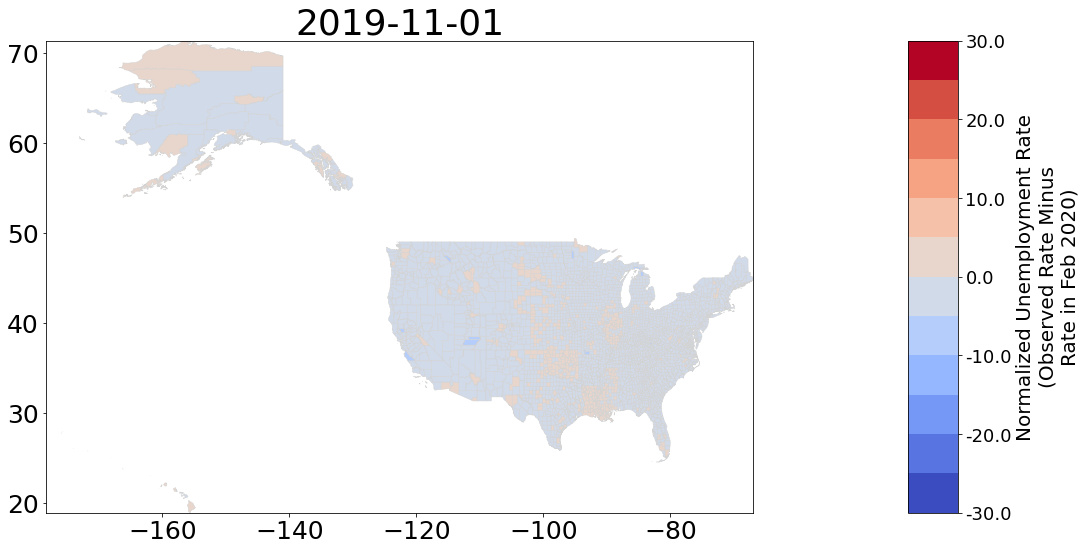

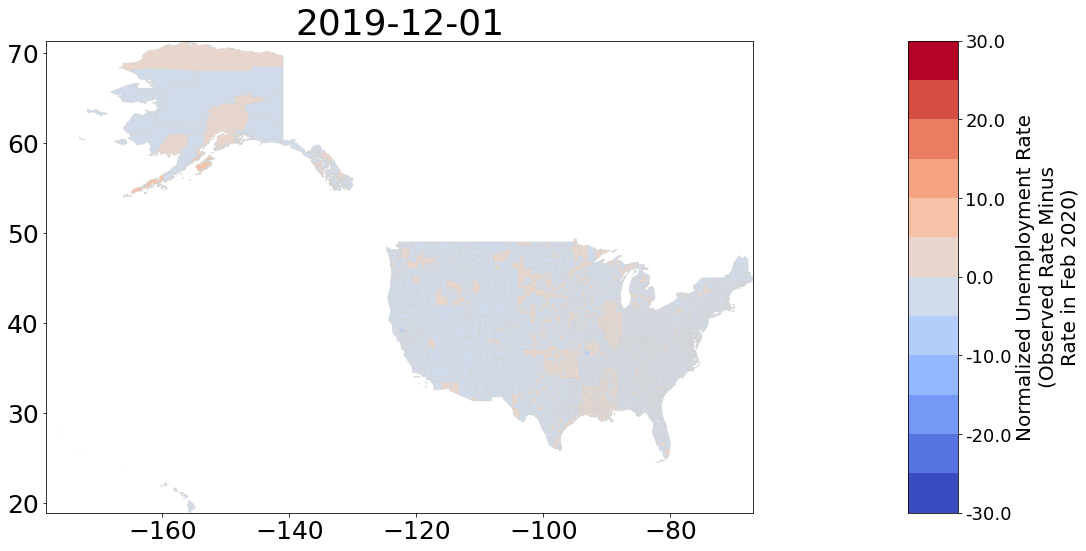

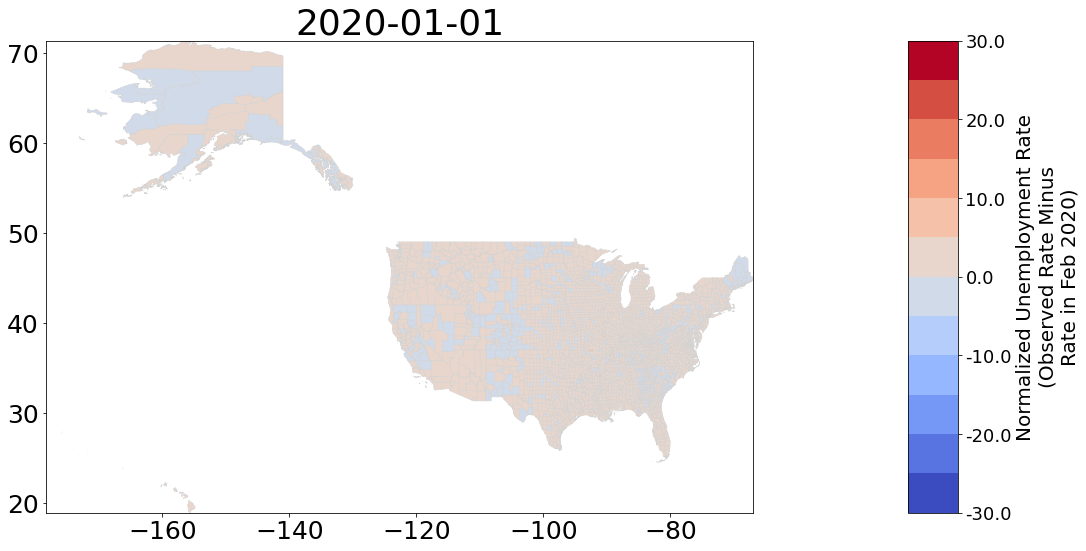

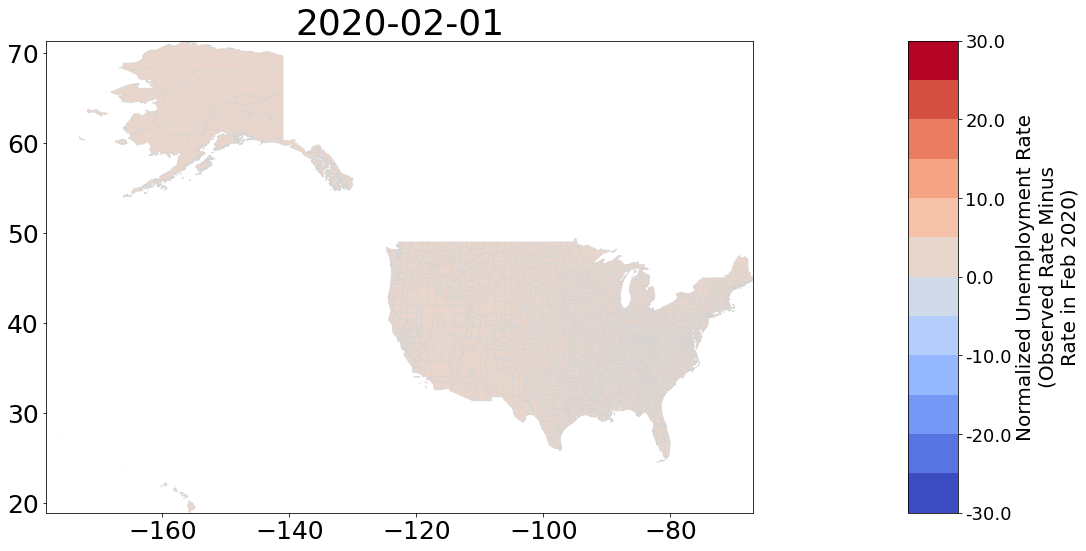

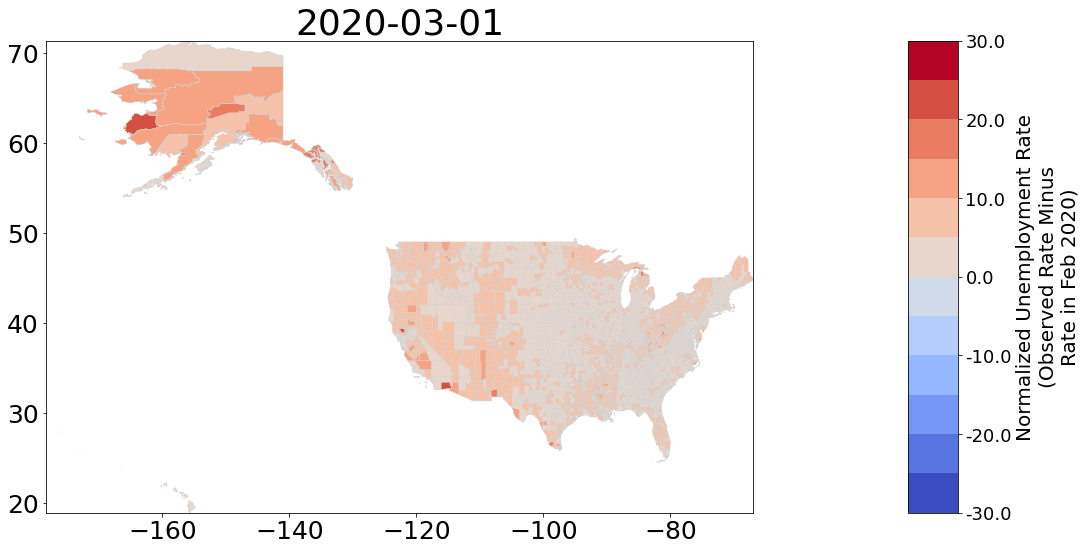

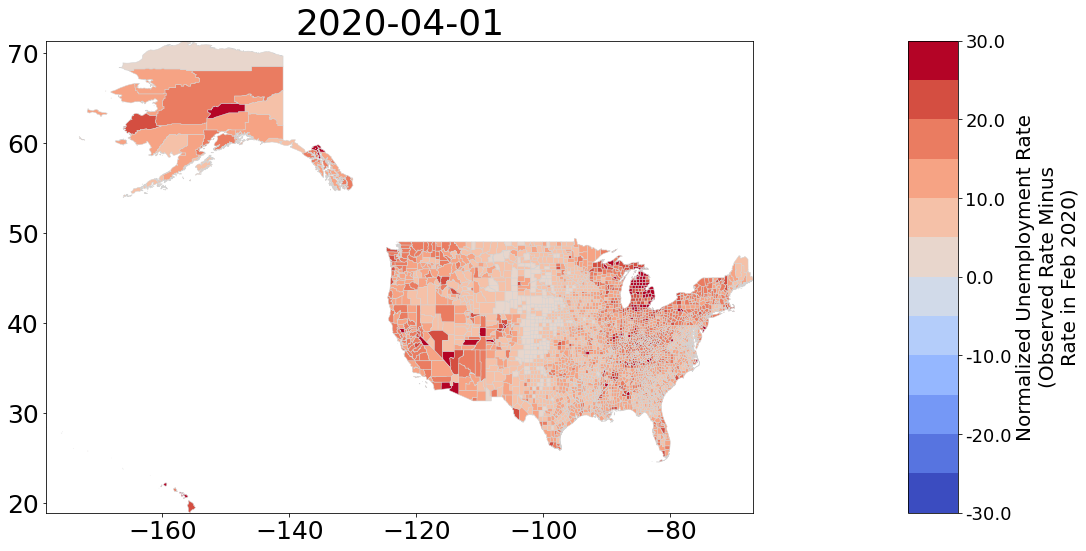

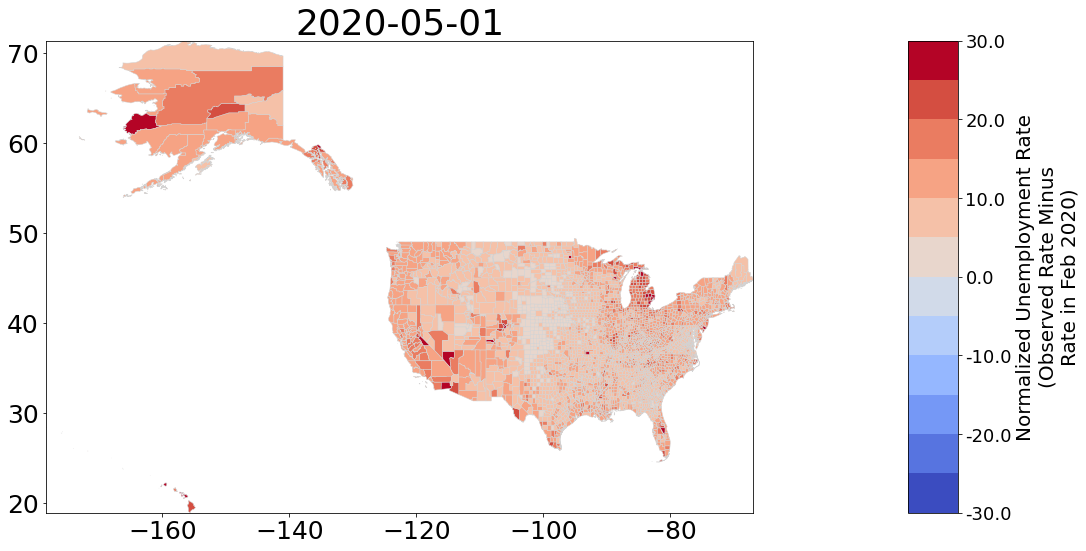

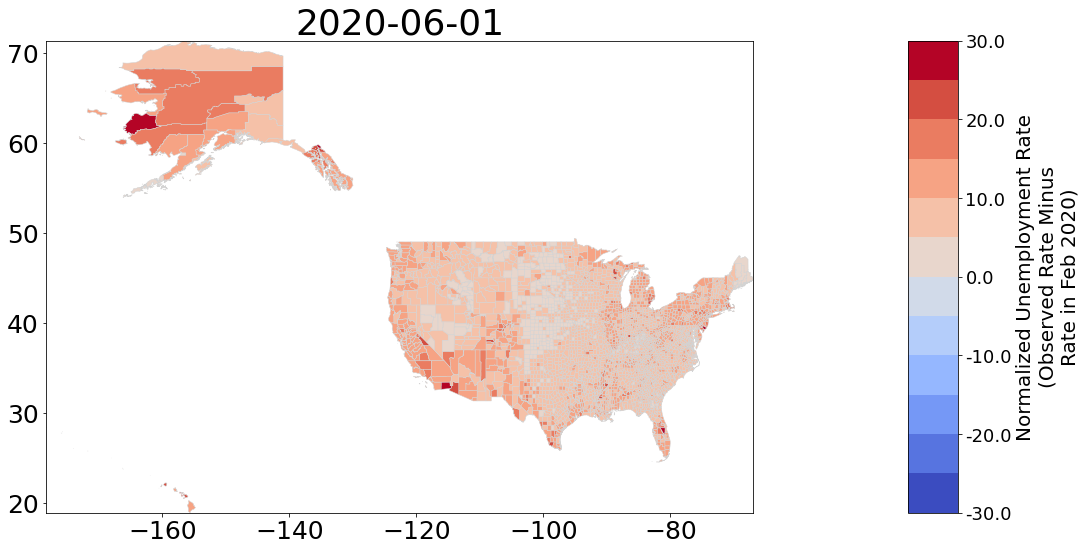

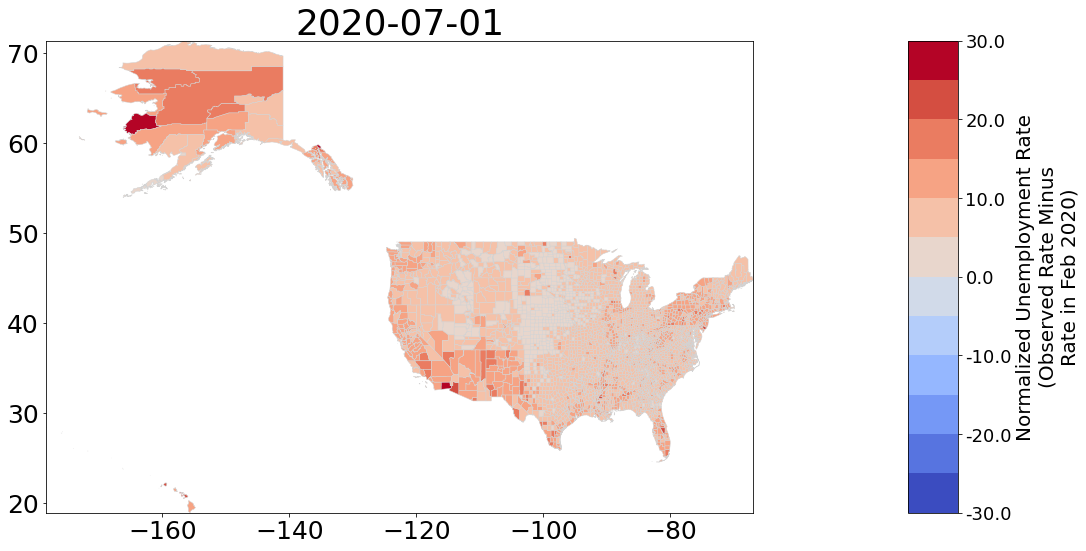

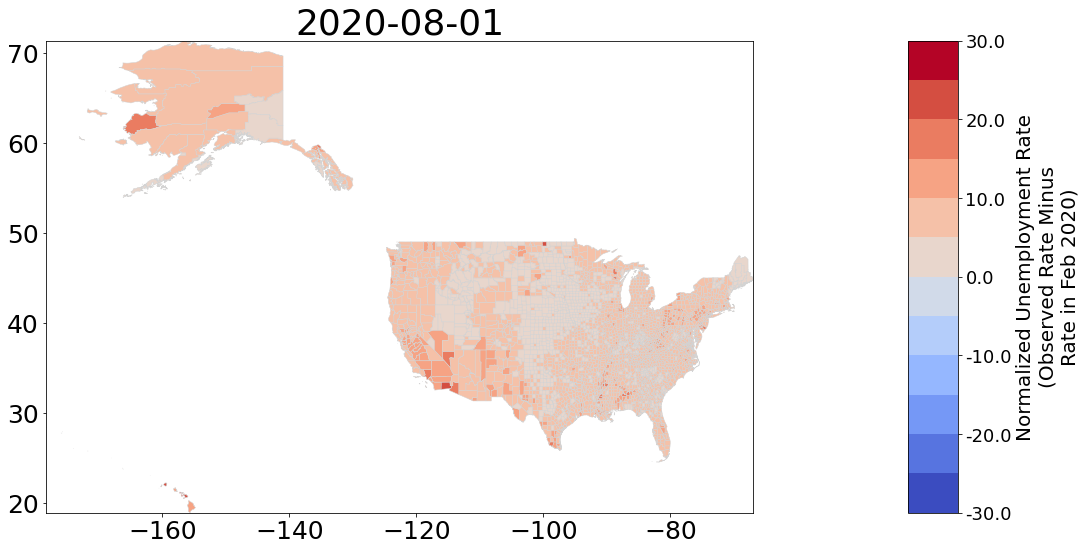

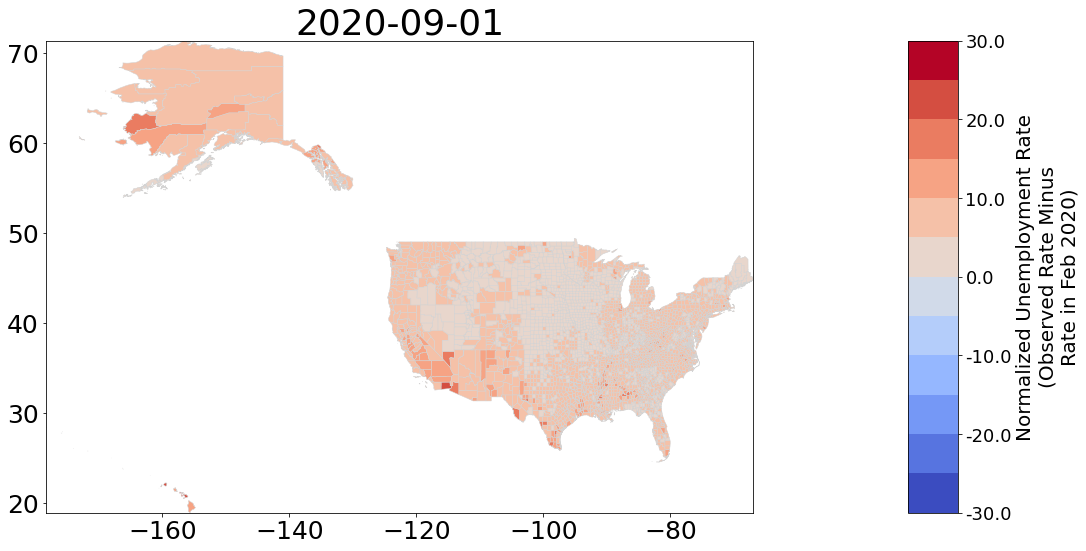

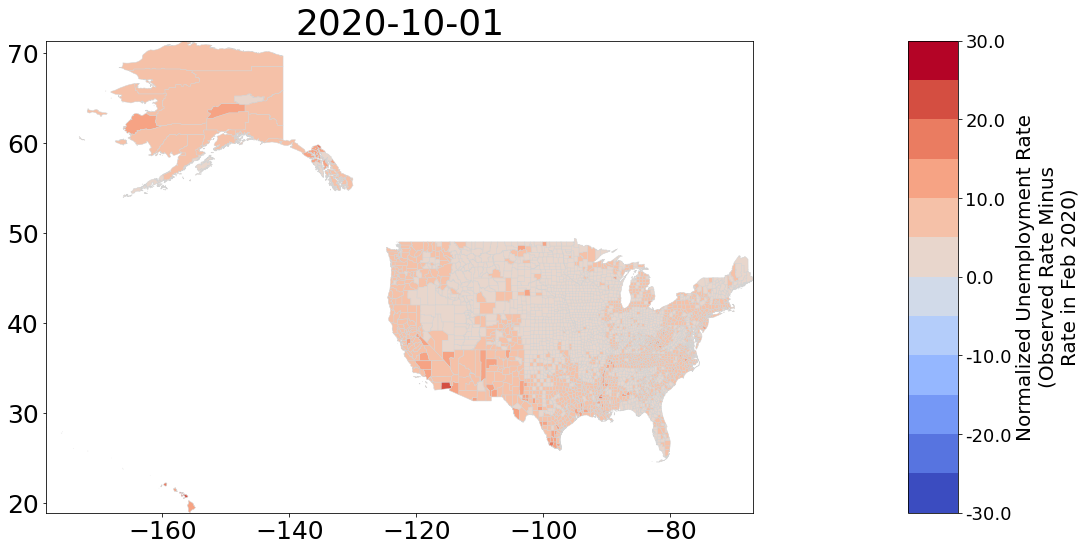

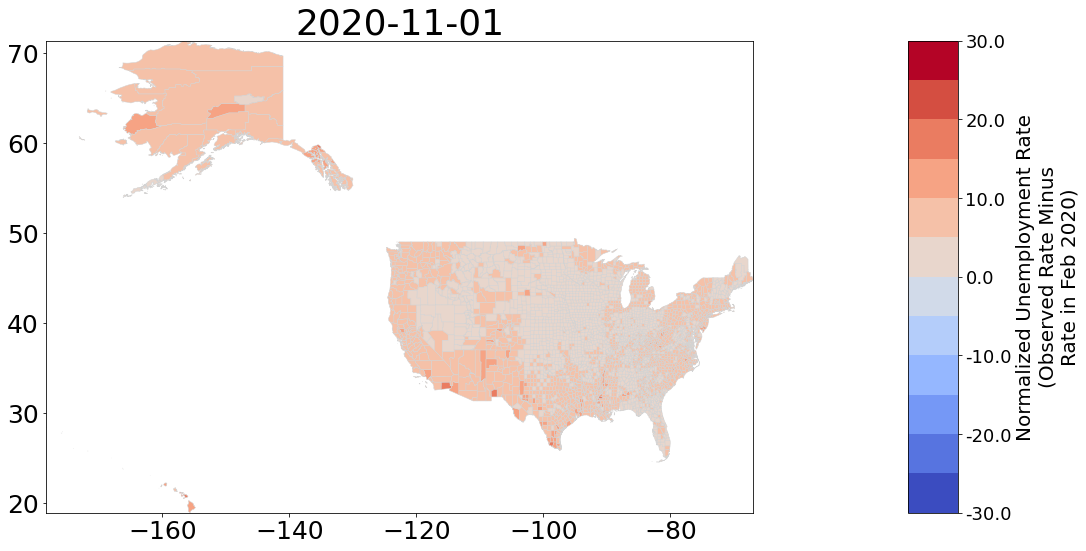

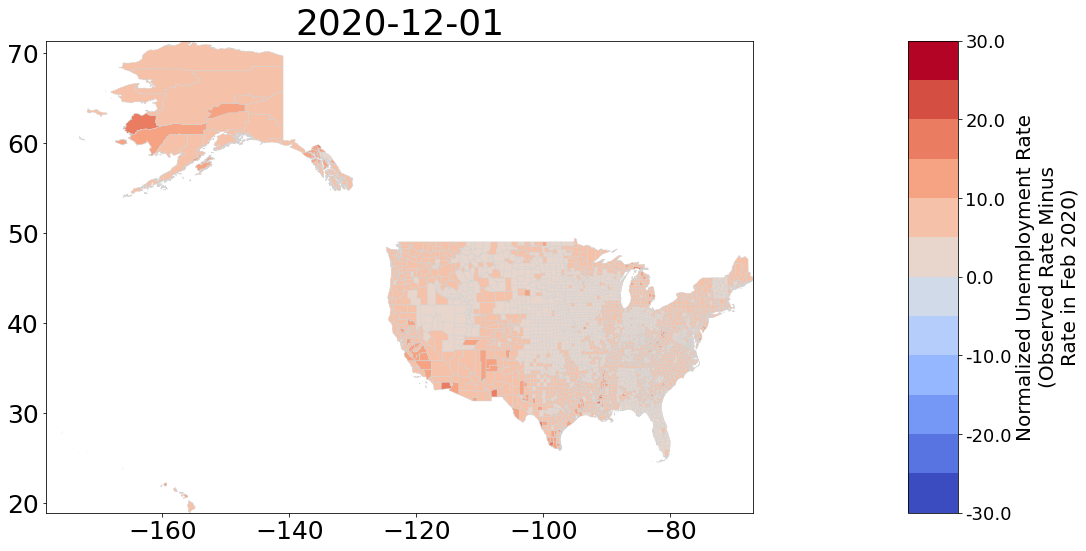

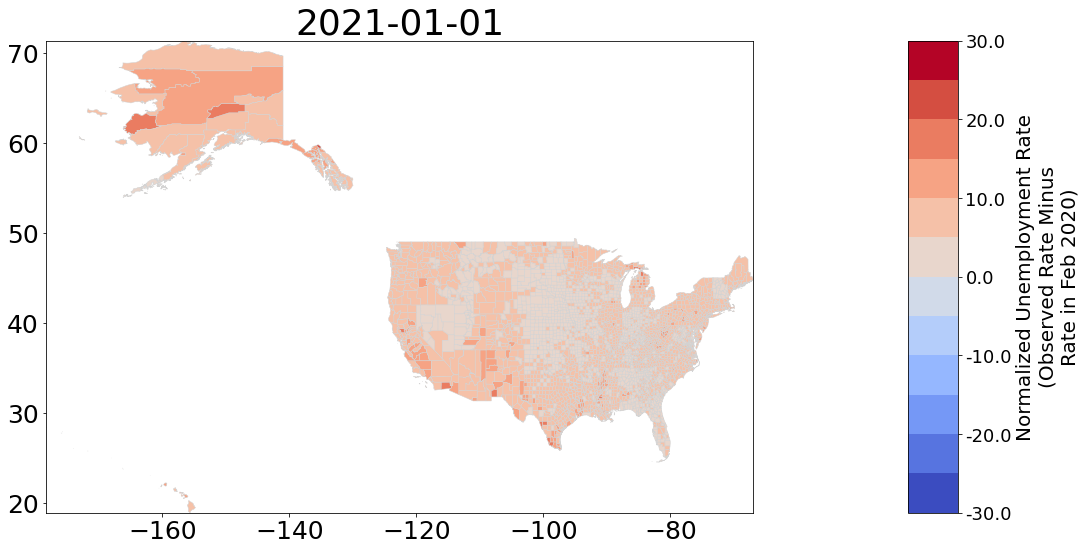

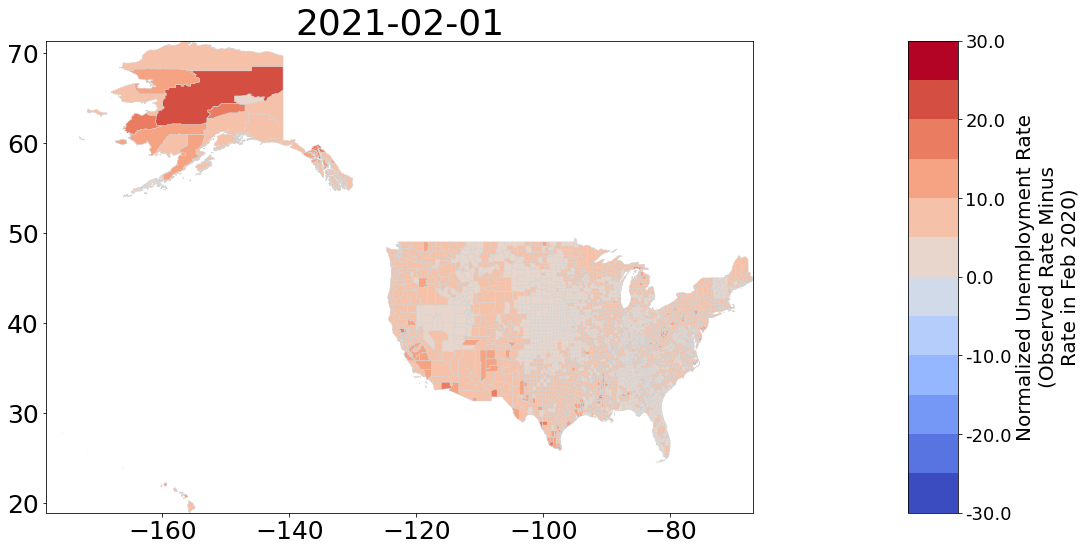

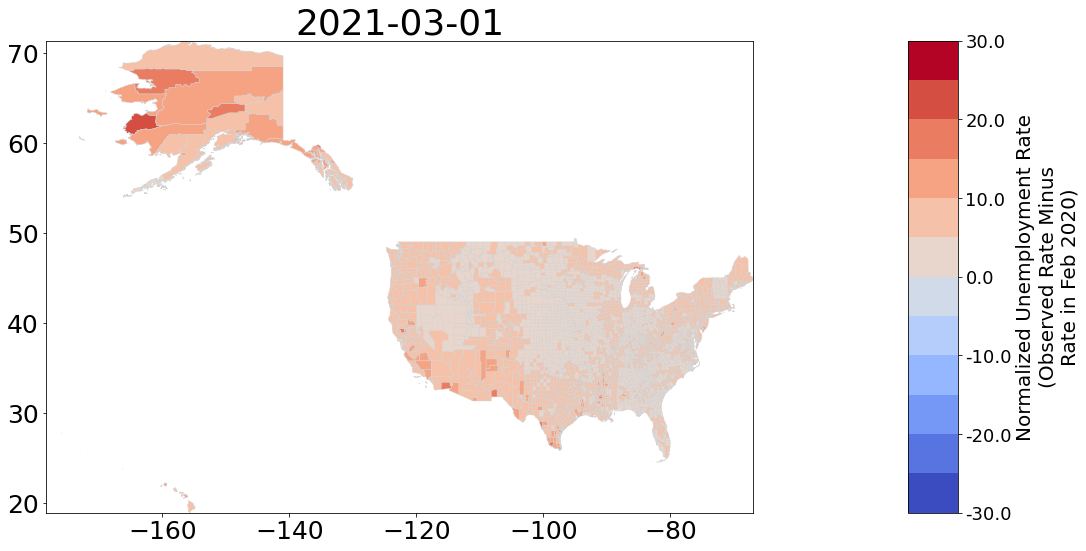

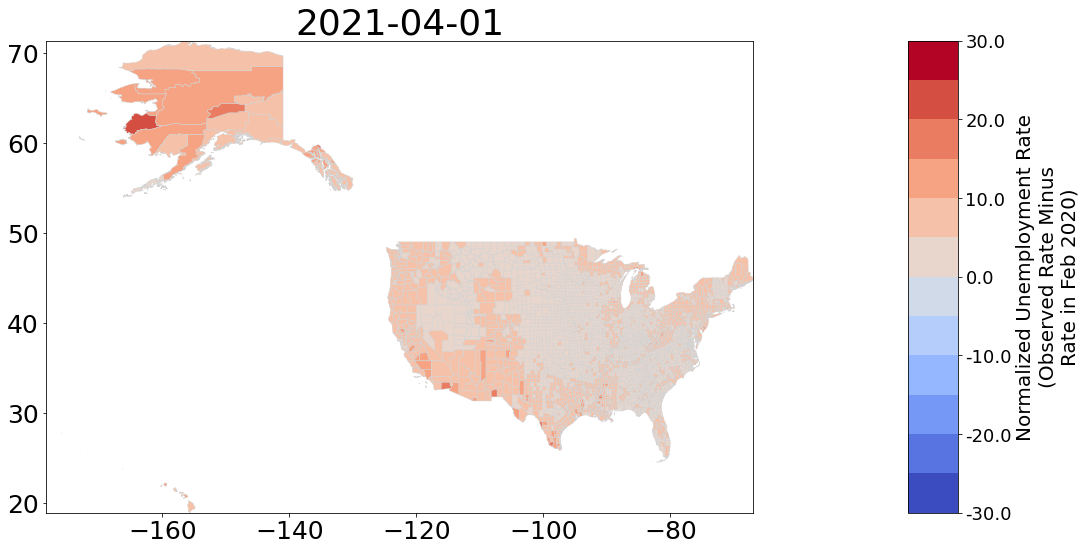

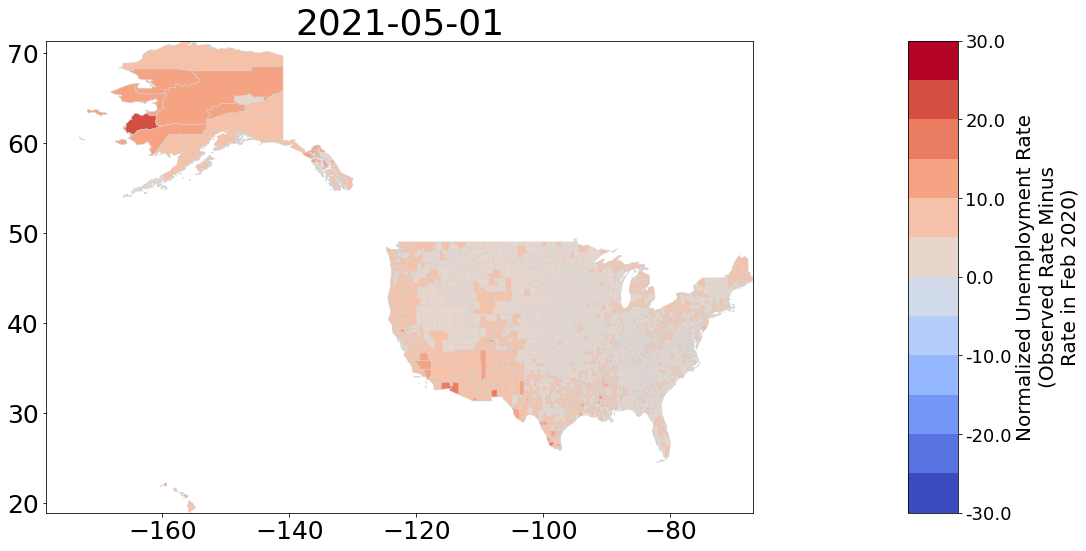

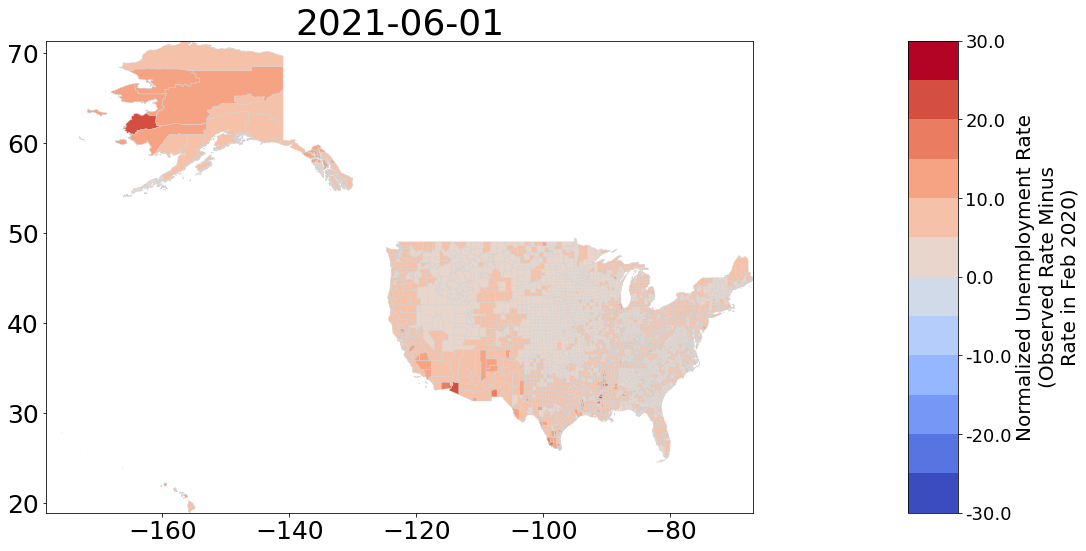

In [16]:
# pp = PdfPages("Normalized County Unemployment Rate.pdf")
df = u_data[new_key]#.dropna(axis=0)

for date in dates:
    # accomplishes same outcome as date.replace("-", " 20")
    title_date = str(date)[:10]
    fig, ax = plt.subplots(figsize=(19,9),
                          subplot_kw = {"aspect":"equal"})
    plt.rcParams.update({"font.size": 30})

    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    # set range color bar values
    vmin = -30# n_u_data["Unemployment Rate"].min()
    vmax = 30
    cmap = cm.get_cmap("coolwarm", 12)
    norm = cm.colors.Normalize(vmin=vmin, vmax=vmax)
    ### add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # prepare space for colorbar
    divider = make_axes_locatable(ax)
    size = "5%"
    cax = divider.append_axes("right", size = size, pad = .1)
    # add colorbar to figure
    cbar = fig.colorbar(sm, cax=cax, cmap= cmap)
    cbar.ax.tick_params(labelsize=18)
    vals = list(cbar.ax.get_yticks())
    vals.append(vmax)
    cbar.ax.set_yticklabels(vals)
    cbar.ax.set_ylabel("Normalized "+key + "\n(Observed Rate Minus\nRate in Feb 2020)", fontsize=20)
    
    df.plot(ax=ax, cax=ax, column = date,
            vmin=vmin, vmax=vmax,
            cmap=cmap, legend=False, 
            linewidth = .5, edgecolor="lightgrey",norm=norm)
    ax.set_title(title_date)
    plt.show()
#     pp.savefig(fig, bbox_inches = "tight")
    plt.close()
# pp.close()

We can see that unemployment rates tended to increase in regions hardest hit by COVID-19 early on. While the correlation is not perfect, the jump in unemployment in the northeast, including New Jersey, and in Michigan seem to follow this trend. Still, other factors matter. For example, the fall in oil prices seems to have impacted western Texas and western North Dakota. And although spread was limited on the West Coast, especially in California, a relatively strict lockdown there seems to be associated with higher levels of unemployment.

The interested student would benefit from running a panel regression ([see Chapter 8](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Textbook/Chapter%208%20-%20Advanced%20Data%20Analysis.ipynb)) that includes factors like the stringency of lockdown and the severity of spread of COVID-19, along with other variables relevant to the level of unemployment, to estimate the effects of these elements on the overall level of unemployment.

## Mapping Economic Freedom and Economic Performance 

### Add Economic Freedom Data
[World Map Reference](https://geopandas.org/en/stable/docs/user_guide/mapping.html)

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [19]:
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

### Homework

1. Find a way to represent the entire time series in a single file. You may either save a visualization for every data on separate pages in a pdf or you may create an MP4 or GIF file. Make sure that for every frame, the correct date is indicated. See how to accomplish this [here](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Projects/COVID19/Visualizing%20COVID-19%20Data%20at%20the%20State%20and%20County%20Levels%20in%20Python%20-%20Part%20III.ipynb). Differentiate your answer from the template provided in at least 3 ways. Identify *how* your output is differentiated.

2. Select a different time series data (e.g., incomes, etc...) set at the county level that has at least 20 observations. Create a map of the latest obervation of the data. Like with the covid data in (1), create a file that holds a visualization for every observation.
